In [ ]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import classification_report
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

Download and load the dataset

In [ ]:
import kagglehub  # Script to download dataset using Kagglehub

path = kagglehub.dataset_download("uciml/sms-spam-collection-dataset")
path = os.path.join(path, 'spam.csv')

print("Path to dataset files:", path)

Path to dataset files: /root/.cache/kagglehub/datasets/uciml/sms-spam-collection-dataset/versions/1/spam.csv


In [ ]:
df = pd.read_csv(path, encoding='latin1')
print(df.head())

     v1                                                 v2 Unnamed: 2  \
0   ham  Go until jurong point, crazy.. Available only ...        NaN   
1   ham                      Ok lar... Joking wif u oni...        NaN   
2  spam  Free entry in 2 a wkly comp to win FA Cup fina...        NaN   
3   ham  U dun say so early hor... U c already then say...        NaN   
4   ham  Nah I don't think he goes to usf, he lives aro...        NaN   

  Unnamed: 3 Unnamed: 4  
0        NaN        NaN  
1        NaN        NaN  
2        NaN        NaN  
3        NaN        NaN  
4        NaN        NaN  


Clean and prepare the data

In [ ]:
# Drop extra columns and rename useful ones
df.drop(['Unnamed: 2', 'Unnamed: 3', 'Unnamed: 4'], axis=1, inplace=True)
df.rename(columns={'v1': 'label', 'v2': 'text'}, inplace=True)

# Encode labels: convert 'ham'/'spam' to 0/1
le = LabelEncoder()
df['label'] = le.fit_transform(df['label'])
print("Unique labels after encoding:", df['label'].unique())
print("Class distribution:\n", df['label'].value_counts())

Unique labels after encoding: [0 1]
Class distribution:
 label
0    4825
1     747
Name: count, dtype: int64


Split the dataset

In [ ]:
# Splitting dataset into training, validation and testing sets
X_train, X_temp, y_train, y_temp = train_test_split(df['text'], df['label'], test_size=0.3, stratify=df['label'], random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, stratify=y_temp, random_state=42)

In [ ]:
print("Training set class distribution:")
print(y_train.value_counts())

print("\nValidation set class distribution:")
print(y_val.value_counts())

print("\nTest set class distribution:")
print(y_test.value_counts())

Training set class distribution:
label
0    3377
1     523
Name: count, dtype: int64

Validation set class distribution:
label
0    724
1    112
Name: count, dtype: int64

Test set class distribution:
label
0    724
1    112
Name: count, dtype: int64


Tokenize the texts for LSTM

In [ ]:
# Define vocabulary size and maximum sequence length
vocab_size = 5000
max_length = 100

tokenizer = Tokenizer(num_words=vocab_size, oov_token="<OOV>")
tokenizer.fit_on_texts(X_train)

# Convert texts to sequences
X_train_seq = tokenizer.texts_to_sequences(X_train)
X_val_seq = tokenizer.texts_to_sequences(X_val)
X_test_seq = tokenizer.texts_to_sequences(X_test)

# Pad sequences to ensure equal length
X_train_pad = pad_sequences(X_train_seq, maxlen=max_length, padding='post', truncating='post')
X_val_pad = pad_sequences(X_val_seq, maxlen=max_length, padding='post', truncating='post')
X_test_pad = pad_sequences(X_test_seq, maxlen=max_length, padding='post', truncating='post')

Build the LSTM model

In [ ]:
# Training model
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(input_dim=vocab_size, output_dim=128),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64, dropout=0.2, recurrent_dropout=0.2)),
    tf.keras.layers.Dense(1, activation='sigmoid')  # Binary classification
])

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [ ]:
# Putting input shape into model and getting its summary
model.build(input_shape=(None, max_length))
model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding_2 (Embedding)              │ (None, 100, 128)            │         640,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_2 (Bidirectional)      │ (None, 128)                 │          98,816 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 1)                   │             129 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 738,945 (2.82 MB)

 Trainable params: 738,945 (2.82 MB)

 Non-trainable params: 0 (0.00 B)

Compute Class Weights to Handle Imbalance

In [ ]:
class_weights_array = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(y_train),
    y=y_train
)
class_weights = {i: class_weights_array[i] for i in range(len(class_weights_array))}
print("Class weights:", class_weights)

Class weights: {0: 0.5774355937222386, 1: 3.72848948374761}


 Train the Model with Class Weights

In [ ]:
history = model.fit(
    X_train_pad, y_train,
    epochs=10,
    batch_size=16,
    validation_data=(X_val_pad, y_val),
    class_weight=class_weights  # This helps model to pay more attention to spam class (which is minority)
)


Epoch 1/10
244/244 ━━━━━━━━━━━━━━━━━━━━ 77s 257ms/step - accuracy: 0.8724 - loss: 0.4236 - val_accuracy: 0.9880 - val_loss: 0.0544
Epoch 2/10
244/244 ━━━━━━━━━━━━━━━━━━━━ 89s 288ms/step - accuracy: 0.9847 - loss: 0.0951 - val_accuracy: 0.9677 - val_loss: 0.1157
Epoch 3/10
244/244 ━━━━━━━━━━━━━━━━━━━━ 87s 309ms/step - accuracy: 0.9940 - loss: 0.0426 - val_accuracy: 0.9450 - val_loss: 0.1805
Epoch 4/10
244/244 ━━━━━━━━━━━━━━━━━━━━ 66s 270ms/step - accuracy: 0.9939 - loss: 0.0230 - val_accuracy: 0.9809 - val_loss: 0.0645
Epoch 5/10
244/244 ━━━━━━━━━━━━━━━━━━━━ 56s 228ms/step - accuracy: 0.9983 - loss: 0.0062 - val_accuracy: 0.9844 - val_loss: 0.0593
Epoch 6/10
244/244 ━━━━━━━━━━━━━━━━━━━━ 82s 228ms/step - accuracy: 0.9991 - loss: 0.0047 - val_accuracy: 0.9856 - val_loss: 0.0634
Epoch 7/10
244/244 ━━━━━━━━━━━━━━━━━━━━ 81s 225ms/step - accuracy: 1.0000 - loss: 9.3339e-04 - val_accuracy: 0.9868 - val_loss: 0.0680
Epoch 8/10
244/244 ━━━━━━━━━━━━━━━━━━━━ 86s 241ms/step - accuracy: 0.9988 - los

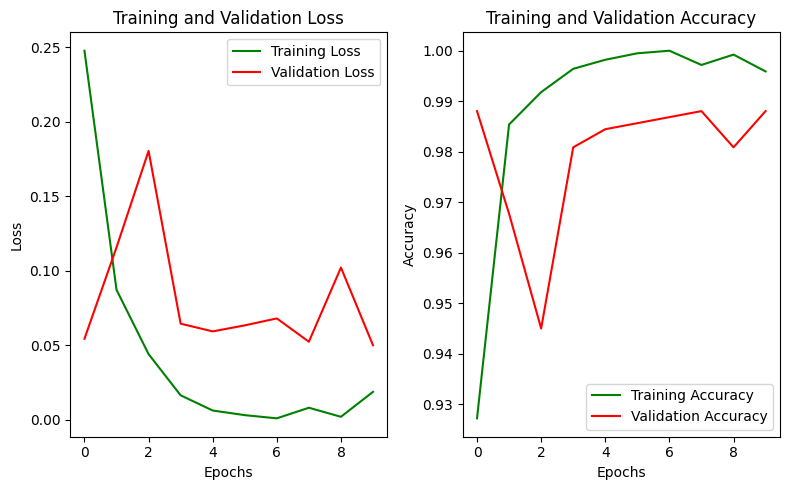

In [ ]:
# Size of figure
plt.figure(figsize=(8, 5))

# Loss Plot
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss', c='g')
plt.plot(history.history['val_loss'], label='Validation Loss', c='r')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Accuracy Plot
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Training Accuracy', c='g')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy', c='r')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Show the plot
plt.tight_layout()
plt.show()

Evaluate the Model

In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

# Make predictions
y_pred_probs = model.predict(X_test_pad)  # Get probability scores
y_pred = (y_pred_probs > 0.5).astype(int)  # Convert probabilities to binary labels

# Print evaluation metrics
print(f"Accuracy: {accuracy_score(y_test, y_pred)}")
print(f"Precision: {precision_score(y_test, y_pred)}")
print(f"Recall: {recall_score(y_test, y_pred)}")
print(f"F1 Score: {f1_score(y_test, y_pred)}")

27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step
Accuracy: 0.9904306220095693
Precision: 0.9905660377358491
Recall: 0.9375
F1 Score: 0.963302752293578


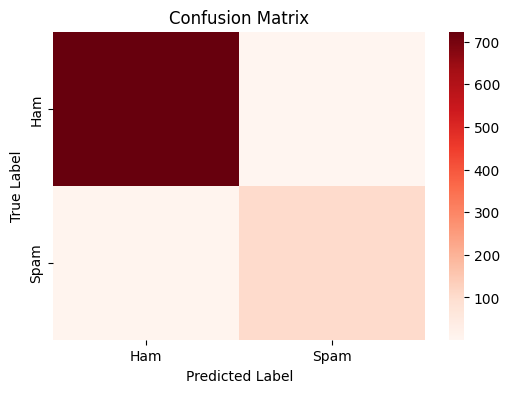

In [ ]:
# Creating confusion Matrix
cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(6, 4))
sns.heatmap(cm, cmap="Reds", xticklabels=["Ham", "Spam"], yticklabels=["Ham", "Spam"])
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()

Inference testing

In [ ]:
# https://blog.textingbase.com/how-to-identify-spam-text-messages#:~:text=Scammers%20send%20texts%20claiming%20that,overpayment%20on%20your%20AMEX%20account.
# Example real text (spam message)
X_spam = ["We’re happy to inform you that you’re entitled to a refund for overpayment on your AMEX account. Click on this link [Link] below to claim your refund."]

X_spam_seq = tokenizer.texts_to_sequences(X_spam) # Convert to sequence
X_spam_pad = pad_sequences(X_spam_seq, maxlen=max_length, padding='post', truncating='post') # Pad the sequence to match training input shape
y_pred_prob = model.predict(X_spam_pad)[0, 0]  # Make a prediction

y_pred_label = "Spam" if y_pred_prob > 0.5 else "Not Spam" # Interpret the result

# Print results
print(f"Predicted Probability: {y_pred_prob:.2f}")
print(f"Predicted Label: {y_pred_label}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step
Predicted Probability: 1.00
Predicted Label: Spam


In [ ]:
X_ham = ["Mr.Alibek, I am texting you with purpose to request you to set me attendance higher than 70%, so that I can take final exam and not go to summer trimester"]

X_ham_seq = tokenizer.texts_to_sequences(X_ham) # Convert to sequence
X_ham_pad = pad_sequences(X_ham_seq, maxlen=max_length, padding='post', truncating='post') # Pad the sequence to match training input shape
y_pred_prob = model.predict(X_ham_pad)[0, 0]  # Make a prediction

y_pred_label = "Spam" if y_pred_prob > 0.5 else "Not Spam" # Interpret the result

# Print results
print(f"Predicted Probability: {y_pred_prob:.2f}")
print(f"Predicted Label: {y_pred_label}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
Predicted Probability: 0.00
Predicted Label: Not Spam
